<a href="https://colab.research.google.com/github/kkrusere/EV_Market-Analysis-and-Consumer-Behavior/blob/main/EV_YTV_Summarizer_Interpreter_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Install Required Libraries

In [ ]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/118.0.5993.70/linux64/chromedriver-linux64.zip -P /tmp/
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver-linux64/chromedriver
mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver
pip install selenium chromedriver_autoinstaller
pip install bitsandbytes
pip install accelerate
pip install trl peft
pip install datasets
pip install rouge-score
pip install huggingface_hub
pip install transformers
pip install boto3

# **Fine-tuning the LED Model for Long-Sequence Summarization**

**Introduction**

In this guide, we'll fine-tune the LED (Longformer Encoder-Decoder) model to perform interpretation and summarization on long sequences of text. The LED model is designed to handle long documents (up to 16,384 tokens), making it suitable for our task involving lengthy inputs.

**Objectives:**

- Install and import necessary libraries.
- Prepare and preprocess the dataset.
- Fine-tune the LED model for summarization.
- Evaluate the fine-tuned model.
- Generate summaries using the fine-tuned model.


## **Importing Libraries and loading functions for data Collection and Preparation**


In [2]:
# Standard library imports
import json
import os
import shutil
import sys
import random
import requests
import re
import time
import datetime
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from IPython.display import display

# Third-party imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from datasets import Dataset

from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    TaskType,
    get_peft_model,
)
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    LEDTokenizer,
    LEDForConditionalGeneration,
    BartForConditionalGeneration,
    BartTokenizer,
    BitsAndBytesConfig,
    EarlyStoppingCallback,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    Trainer,
    TrainingArguments,
    logging,
    pipeline,
    AdamW,
)


import boto3
from botocore.exceptions import ClientError
from boto3.dynamodb.conditions import Key
from boto3.dynamodb.types import TypeDeserializer


from google.colab import drive, userdata
from huggingface_hub import login
# Mount Google Drive
drive.mount('/content/drive')
# Change the working directory to the desired location in Google Drive
os.chdir("/content/drive/MyDrive/NLP_Data")


# Retrieve the Hugging Face API token from user data
huggingface_token = userdata.get('Hugging_Face_Hub_API_TOKEN')
# Log in to Hugging Face Hub
login(huggingface_token, add_to_git_credential=True)

# Setting up AWS Credentials into Environment Variables
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('aws_access_key_id')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('aws_secret_access_key')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('aws_region')


Mounted at /content/drive
Token is valid (permission: fineGrained).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
# Third-party imports
import chromedriver_autoinstaller

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.common.exceptions import (
    ElementNotInteractableException,
    TimeoutException,
)
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

################################################################################
# Initialize and Close WebDriver
def init_webdriver():
    """Initializes and returns a Chrome WebDriver instance with options."""
    try:
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--headless")  # Run in headless mode
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chromedriver_autoinstaller.install()  # Automatically install chromedriver
        driver = webdriver.Chrome(options=chrome_options)
        print("WebDriver initialized successfully")
        return driver
    except Exception as e:
        print(f"Failed to initialize WebDriver: {e}")
        raise


def close_webdriver(driver):
    """Closes the provided WebDriver instance."""
    driver.quit()
    print("WebDriver successfully closed")


################################################################################
# YouTube URL and Video ID Handling
def get_youtube_url(video_id):
    """Constructs a YouTube URL from a given video ID."""
    return f"https://www.youtube.com/watch?v={video_id}"


def get_youtube_videoID(youtube_url):
    """Extracts the YouTube video ID from a given YouTube URL."""
    if not youtube_url:
        return None
    try:
        if "watch?v=" in youtube_url:
            video_id = youtube_url.split("watch?v=")[1].split("&")[0]
            return video_id
        elif "youtu.be/" in youtube_url:
            video_id = youtube_url.split("youtu.be/")[1].split("?")[0]
            return video_id
        else:
            return None
    except Exception as e:
        print(f"Error extracting video ID: {e}")
        return None


################################################################################
# Fetch Comments HTML
def get_comments_html(video_url, driver):
    """
    Fetches the HTML content of the comments section from a YouTube video.

    Args:
        video_url (str): The URL of the YouTube video from which to fetch comments.
        driver: An initialized WebDriver instance (from Selenium).

    Returns:
        str: The HTML content of the comments section.

    Raises:
        TimeoutException: If the comments section does not load within the specified time.
    """
    # Wait until the comments section is loaded
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "ytd-comments"))
    )

    # Scroll to the comments section to load initial comments
    driver.execute_script(
        "window.scrollTo(0, document.documentElement.scrollHeight);"
    )

    # Set initial values for dynamic loading
    last_height = driver.execute_script(
        "return document.documentElement.scrollHeight"
    )
    scroll_pause_time = 2  # Time to wait between scrolls
    max_scrolls = 100  # Max number of scrolls to ensure all comments are loaded
    scroll_count = 0

    while scroll_count < max_scrolls:
        # Scroll down to the bottom
        driver.execute_script(
            "window.scrollTo(0, document.documentElement.scrollHeight);"
        )

        # Wait for new comments to load dynamically
        time.sleep(scroll_pause_time)

        # Check the new scroll height and compare it with the last height
        new_height = driver.execute_script(
            "return document.documentElement.scrollHeight"
        )
        if new_height == last_height:
            # If the height hasn't changed, try one more scroll to ensure all comments are loaded
            time.sleep(scroll_pause_time)
            new_height = driver.execute_script(
                "return document.documentElement.scrollHeight"
            )
            if new_height == last_height:
                print("All comments have been loaded.")
                break

        last_height = new_height
        scroll_count += 1

    # Get the HTML of the comments section
    comments_html = driver.page_source

    # Close the driver
    close_webdriver(driver)

    return comments_html


################################################################################
# Parse Comments
def get_comment_thread_renderers(comments_html):
    """
    Parses the provided HTML content to extract YouTube comment threads.

    Args:
        comments_html (str): The HTML content of the comments section of a YouTube video.

    Returns:
        list: A list of `ytd-comment-thread-renderer` elements found in the HTML.
    """
    soup = BeautifulSoup(comments_html, "html.parser")
    comment_thread_renderers = soup.find_all(
        "ytd-comment-thread-renderer",
        class_="style-scope ytd-item-section-renderer",
    )
    return comment_thread_renderers


def get_comments(comment_thread_renderers):
    """
    Extracts comments and associated data from the list of comment thread renderers.

    Args:
        comment_thread_renderers (list): List of 'ytd-comment-thread-renderer' elements.

    Returns:
        tuple: A tuple containing a list of comment texts and a list of dictionaries with comment data.
    """
    comments = []
    comments_data = []

    for comment_thread_renderer in comment_thread_renderers:
        # Extract the comment text
        comment_text_element = comment_thread_renderer.find(
            "yt-attributed-string", id="content-text"
        )
        comment_text = (
            comment_text_element.get_text(strip=True)
            if comment_text_element
            else None
        )

        # Extract the number of likes
        like_count_element = comment_thread_renderer.find(
            "span", class_="style-scope ytd-comment-engagement-bar"
        )
        like_count = (
            like_count_element.get_text(strip=True)
            if like_count_element
            else None
        )

        # Extract the number of replies
        reply_count_element = comment_thread_renderer.find(
            "ytd-button-renderer", id="more-replies"
        )
        reply_count = (
            reply_count_element.get_text(strip=True)
            if reply_count_element
            else None
        )

        comments.append(comment_text)
        comments_data.append(
            {
                "comment_text": comment_text,
                "like_count": like_count,
                "reply_count": reply_count,
            }
        )

    return comments, comments_data


################################################################################
# Retrieve Video Comments
def get_video_comments(video_url, driver):
    """
    Retrieves comments from the provided YouTube video URL.

    Args:
        video_url (str): The URL of the YouTube video.
        driver: An initialized WebDriver instance (from Selenium).

    Returns:
        list: A list of comments and their data.
    """
    comments_html = get_comments_html(video_url, driver)
    comment_thread_renderers = get_comment_thread_renderers(comments_html)
    _, comments_data = get_comments(comment_thread_renderers)
    return comments_data


################################################################################
# Clean and Summarize Video Description
def clean_description(video_data_dict, model_path="./Bart-Desc-Sum-fine-tuned-lora-model"):
    """
    Cleans and summarizes YouTube video descriptions using a fine-tuned LoRA model.

    Args:
        video_data_dict (dict): A dictionary containing video data with keys 'channel_name', 'video_title', and 'video_description'.
        model_path (str, optional): Path to the fine-tuned summarization model.

    Returns:
        str: The cleaned and summarized description.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load the fine-tuned model and tokenizer
    pipe = pipeline("summarization", model=model_path, tokenizer=model_path, device=device)

    # Construct the input text
    input_text = (
        f"Channel: {video_data_dict['channel_name']}, "
        f"Title: {video_data_dict['video_title']}, "
        f"Description: {video_data_dict['video_description']}"
    )
    tokenizer = BartTokenizer.from_pretrained(model_path)
    input_length = len(tokenizer.encode(input_text))
    max_length = int(input_length * 0.5)


    # Generate a cleaned description
    cleaned_description = pipe(input_text, max_length=max_length)[0]["summary_text"]

    return cleaned_description


################################################################################
# Fetch Video Data
def get_video_data(video_id):
    """
    Fetches video data from YouTube given a video ID.

    Args:
        video_id (str): The ID of the YouTube video to fetch data for.

    Returns:
        dict: A dictionary containing the video data with keys:
            - 'channel_name'
            - 'video_title'
            - 'video_description'
            - 'comments'
    """
    driver = init_webdriver()
    video_url = f"https://www.youtube.com/watch?v={video_id}"
    video_data = {}

    try:
        driver.get(video_url)

        # Handle YouTube consent dialog if it appears
        try:
            consent_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable(
                    (By.XPATH, '//button[contains(., "I agree")]')
                )
            )
            consent_button.click()
        except TimeoutException:
            print("No consent dialog found or already handled.")

        # Handle any other potential modal dialogs that might pop up
        try:
            dialog_close_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable(
                    (By.XPATH, '//button[@aria-label="Close"]')
                )
            )
            dialog_close_button.click()
        except TimeoutException:
            print("No additional modal dialogs found.")

        try:
            # Wait for the bottom-row element to be present
            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located(
                    (By.XPATH, '//*[@id="bottom-row"]')
                )
            )

            # Locate and click the expand button if it exists
            try:
                expand_button = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located(
                        (By.XPATH, '//tp-yt-paper-button[@id="expand"]')
                    )
                )
                # Use JavaScript to click the element to bypass any overlay issues
                driver.execute_script(
                    "arguments[0].scrollIntoView();", expand_button
                )
                driver.execute_script("arguments[0].click();", expand_button)
            except TimeoutException:
                pass  # Ignore if the expand button is not found

            # Wait for elements to be visible and extract data
            expanded_description = WebDriverWait(driver, 10).until(
                EC.visibility_of_element_located(
                    (By.ID, "description-inline-expander")
                )
            )
            title_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located(
                    (
                        By.XPATH,
                        '//h1[@class="style-scope ytd-watch-metadata"]//yt-formatted-string',
                    )
                )
            )
            channel_name_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located(
                    (
                        By.XPATH,
                        '//ytd-channel-name[@id="channel-name"]//yt-formatted-string//a',
                    )
                )
            )

            video_data = {
                "channel_name": channel_name_element.text,
                "video_title": title_element.text,
                "video_description": expanded_description.text,
            }

            # Clean the description
            cleaned_description = clean_description(video_data)
            video_data["video_description"] = cleaned_description

            # Fetch comments
            comments_data = get_video_comments(video_url, driver)
            video_data["comments"] = comments_data

        except TimeoutException:
            print(
                f"Error processing {video_url}: Elements not found within timeout."
            )

    except Exception as e:
        print(f"Error processing {video_url}: {e}")

    finally:
        # Close the browser when done
        close_webdriver(driver)

    return video_data


################################################################################
# Data Conversion and Cleaning
def convert_to_int(count_str):
    """
    Converts a string representing a large number with suffixes 'K', 'M', or 'B' into an integer.

    Args:
        count_str (str or int): The count string to convert.

    Returns:
        int: The numerical equivalent of the input string.
    """
    if count_str is None:
        return 0

    if isinstance(count_str, str):
        count_str = count_str.strip()
        multiplier = 1

        if "K" in count_str:
            multiplier = 1000
            count_str = count_str.replace("K", "").strip()
        elif "M" in count_str:
            multiplier = 1_000_000
            count_str = count_str.replace("M", "").strip()
        elif "B" in count_str:
            multiplier = 1_000_000_000
            count_str = count_str.replace("B", "").strip()

        # Extract numerical part
        numeric_part = re.findall(r"[-+]?\d*\.\d+|\d+", count_str)
        if numeric_part:
            count_str = numeric_part[0]
        else:
            return 0

        try:
            return int(float(count_str) * multiplier)
        except ValueError:
            return 0
    else:
        try:
            return int(count_str)
        except ValueError:
            return 0


def convert_video_comments_to_dataframe(video_data):
    """
    Converts the video data and its comments into a list of dictionaries.

    Args:
        video_data (dict): The video data containing comments.

    Returns:
        list: A list of dictionaries with comment data.
    """
    if "comments" not in video_data or not video_data["comments"]:
        print("No comments to convert.")
        return []

    rows = []

    for comment in video_data["comments"]:
        row = {
            "channel_name": video_data["channel_name"],
            "video_title": video_data["video_title"],
            "video_description": video_data["video_description"],
            "comment_text": comment["comment_text"],
            "like_count": convert_to_int(comment["like_count"]),
            "reply_count": convert_to_int(comment["reply_count"]),
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    print(f"Converted comments to DataFrame with {len(df)} rows.")
    return df.to_dict(orient="records")


################################################################################
# Prepare the Test Data for Inference
def prepare_test_data_from_dict(data_dict, for_inference=True):
    """
    Prepares the test data for inference from a dictionary.

    Args:
        data_dict (list): List of dictionaries containing comment data.
        for_inference (bool, optional): If True, the output is left empty.

    Returns:
        Dataset: A Hugging Face Dataset object.
    """
    df = pd.DataFrame(data_dict)

    formatted_input_data = [
        {
            "input": (
                f"Channel Name: {row['channel_name']}\n"
                f"Video Title: {row['video_title']}\n"
                f"Description: {row['video_description']}\n"
                f"Comment Text: {row['comment_text']}\n"
            ),
            "output": "Sentiment: , Explanation: ",
        }
        for _, row in df.iterrows()
    ]

    return Dataset.from_list(formatted_input_data)


def tokenize_dataset(dataset, tokenizer):
    """
    Tokenizes the dataset for model inference using the provided tokenizer.

    Args:
        dataset (Dataset): The dataset to tokenize.
        tokenizer: The tokenizer to use.

    Returns:
        Dataset: The tokenized dataset.
    """

    def tokenize_data(example):
        return tokenizer(
            example["input"],
            max_length=512,
            padding="max_length",
            truncation=True,
        )

    return dataset.map(tokenize_data, batched=True)


def run_inference(model, tokenizer, tokenized_dataset):
    """
    Runs inference on the tokenized dataset using the provided model and tokenizer.

    Args:
        model: The fine-tuned model.
        tokenizer: The tokenizer to use.
        tokenized_dataset (Dataset): The tokenized dataset.

    Returns:
        list: A list of predictions.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions = []

    for example in tokenized_dataset:
        inputs = tokenizer(
            example["input"],
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512,
        )
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_length=150, num_beams=5, early_stopping=True
            )

        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)

    return predictions


def get_predictions_from_data_dict(data_dict, model, tokenizer):
    """
    Processes the data from a dictionary, runs inference, and returns the predictions.

    Args:
        data_dict (list): List of dictionaries containing comment data.
        model: The fine-tuned model.
        tokenizer: The tokenizer to use.

    Returns:
        list: A list of predictions.
    """
    formatted_dataset = prepare_test_data_from_dict(data_dict, for_inference=True)
    tokenized_dataset = tokenize_dataset(formatted_dataset, tokenizer)
    predictions = run_inference(model, tokenizer, tokenized_dataset)
    return predictions


################################################################################
# Sentiment and Explanation Processing
def split_sentiment_explanation(item):
    """
    Splits the model's output into sentiment and explanation.

    Args:
        item (str): The model's output string.

    Returns:
        tuple: A tuple containing the sentiment and explanation.
    """
    sentiment_part, explanation_part = item.split(", Explanation: ")
    sentiment = sentiment_part.replace("Sentiment: ", "").strip()
    explanation = explanation_part.strip()
    print(f"Sentiment: {sentiment}, Explanation: {explanation}")
    return sentiment, explanation



################################################################################
# Saving Data to S3
def save_data_to_s3(video_id, processed_video_data, bucket_name =  'experiment-api-data-bucket'):
    """
    Saves processed_video_data to an S3 bucket.

    Args:
        video_id (str): The YouTube video ID.
        processed_video_data (list): The processed video data to save.
        bucket_name (str): The name of the S3 bucket.

    Returns:
        str: The S3 object key where the data is stored.
    """
    s3 = boto3.client('s3')

    # Serialize data to JSON
    data_json = json.dumps(processed_video_data)

    # Define the S3 object key
    s3_key = f"{video_id}.json"

    # Save to S3
    try:
        s3.put_object(Bucket=bucket_name, Key=s3_key, Body=data_json)
        print(f"Data for video_id '{video_id}' saved to S3 bucket '{bucket_name}'.")
        return s3_key
    except ClientError as e:
        print(f"Error saving data to S3: {e.response['Error']['Message']}")
        return None

################################################################################
# Saving S3 Reference to DynamoDB
def save_s3_reference_to_dynamodb(video_id, s3_key, table_name='YouTubeVideoData'):
    """
    Stores the S3 object key and last-updated-on timestamp in DynamoDB, indexed by video_id and last-updated-on.

    Args:
        video_id (str): The YouTube video ID.
        s3_key (str): The S3 object key where the data is stored.
        table_name (str): The name of the DynamoDB table.

    Returns:
        None
    """
    dynamodb = boto3.resource('dynamodb')
    table = dynamodb.Table(table_name)

    # Get the current UTC datetime in ISO 8601 format
    current_time = datetime.datetime.utcnow().isoformat()

    try:
        table.put_item(
            Item={
                'video_id': video_id,
                'last-updated-on': current_time,
                's3_key': s3_key
            }
        )
        print(f"S3 reference for video_id '{video_id}' saved to DynamoDB with timestamp '{current_time}'.")
    except ClientError as e:
        print(f"Error saving S3 reference to DynamoDB: {e.response['Error']['Message']}")

################################################################################
# Retrieving S3 Reference from DynamoDB

def get_latest_s3_reference_from_dynamodb(video_id, table_name='YouTubeVideoData'):
    """
    Retrieves the latest S3 object key and last-updated-on timestamp from DynamoDB using the video_id.

    Args:
        video_id (str): The YouTube video ID.
        table_name (str): The name of the DynamoDB table.

    Returns:
        dict: A dictionary containing 's3_key' and 'last-updated-on'.
    """
    dynamodb = boto3.resource('dynamodb')
    table = dynamodb.Table(table_name)

    try:
        response = table.query(
            KeyConditionExpression=Key('video_id').eq(video_id),
            ScanIndexForward=False,  # Sorts results in descending order
            Limit=1  # Get only the latest item
        )
        items = response.get('Items')
        if items:
            item = items[0]
            print(f"S3 reference for video_id '{video_id}' retrieved from DynamoDB.")
            return {
                's3_key': item.get('s3_key'),
                'last-updated-on': item.get('last-updated-on')
            }
        else:
            print(f"No data found for video_id '{video_id}'.")
            return None
    except ClientError as e:
        print(f"Error retrieving S3 reference from DynamoDB: {e.response['Error']['Message']}")
        return None

################################################################################
# Retrieve Data from S3

def get_data_from_s3(video_id, bucket_name='experiment-api-data-bucket'):
    """
    Retrieves processed_video_data from S3 using the video_id.

    Args:
        video_id (str): The YouTube video ID.
        bucket_name (str): The name of the S3 bucket.

    Returns:
        list: The processed_video_data associated with the video_id.
    """
    s3 = boto3.client('s3')
    s3_key = f"{video_id}.json"

    try:
        response = s3.get_object(Bucket=bucket_name, Key=s3_key)
        data_json = response['Body'].read().decode('utf-8')
        data = json.loads(data_json)
        print(f"Data for video_id '{video_id}' retrieved from S3.")
        return data
    except ClientError as e:
        print(f"Error retrieving data from S3: {e.response['Error']['Message']}")
        return None


################################################################################
# Main Execution Flow
def main(youtube_url):
    """
    Main function to execute all steps.

    Args:
        youtube_url (str): The YouTube video URL.
    """
    video_id = get_youtube_videoID(youtube_url)
    if not video_id:
        print("Invalid YouTube URL.")
        return

    # Step 1 & 2: Collect comments and clean description
    video_data = get_video_data(video_id)
    if not video_data:
        print("Failed to retrieve video data.")
        return

    # Convert comments to DataFrame
    data_dict = convert_video_comments_to_dataframe(video_data)
    if not data_dict:
        print("No comments data available.")
        return

    # Step 3: Sentiment Analysis
    model_path = "./SA-bart-fine-tuned-lora-model"  # Update with your model path
    model = BartForConditionalGeneration.from_pretrained(model_path)
    model.eval()
    tokenizer = BartTokenizer.from_pretrained(model_path)

    predictions = get_predictions_from_data_dict(data_dict, model, tokenizer)
    print("Sentiment analysis completed.")

    processed_video_data = [
        {**data_entry, "sentiment_&_explanations": prediction}
        for data_entry, prediction in zip(data_dict, predictions)
    ]

    return processed_video_data



################################################################################
def retrieve_or_extract_video_data(youtube_url):
    """
    Given a YouTube URL, retrieve the video data from AWS if available;
    if not available, extract from YouTube and store it.
    """
    # Get video ID
    video_id = get_youtube_videoID(youtube_url)
    if not video_id:
        print("Invalid YouTube URL.")
        return None

    # Try to retrieve S3 reference from DynamoDB
    s3_reference = get_latest_s3_reference_from_dynamodb(video_id)
    if s3_reference:
        # Data exists, retrieve from S3
        processed_video_data = get_data_from_s3(video_id)
        print("Data retrieved from AWS.")
        return processed_video_data
    else:
        # Data does not exist, extract from YouTube
        processed_video_data = main(youtube_url)

        if not processed_video_data:
            print("No processed data to save. Exiting.")
            sys.exit(1)

        bucket_name = 'experiment-api-data-bucket'
        # Save data to S3
        s3_key = save_data_to_s3(video_id, processed_video_data)

        if s3_key:
            # Save S3 reference and timestamp to DynamoDB
            save_s3_reference_to_dynamodb(video_id, s3_key)
        else:
            print("Failed to save data to S3. Skipping DynamoDB update.")

    return processed_video_data


In [4]:
def extract_video_info(processed_video_data):
  """
  Extracts channel name, video title, video description, and sentiment_&_explanations list from video data.

  Args:
    processed_video_data: A dictionary containing video information.

  """
  channel_name = processed_video_data[0]['channel_name']
  video_title = processed_video_data[0]['video_title']
  video_description = processed_video_data[0]['video_description']
  sentiment_explanations = []

  for item in processed_video_data:
      sentiment_explanations.append(item['sentiment_&_explanations'])

  data  = {
    "channel_name": channel_name,
    "video_time": video_title,
    "video_description": video_description,
    "sentiment_&_explanations": sentiment_explanations
  }
  return data


## **Prepare the Dataset**

- We need to prepare our dataset for fine-tuning. Since we have specific input data, we'll structure it appropriately.



In [5]:
with open('/content/drive/MyDrive/NLP_Data/EV-YTV_ProcessedDATAinterpr_training_data.json', 'r') as f:
  data = json.load(f)
print(f"Data type: {type(data)} <---->  Data length {len(data)}")

Data type: <class 'dict'> <---->  Data length 56


In [6]:
video_id = '06Q-BbvA48Q'
processed_data = extract_video_info(data[video_id])


Channel Name: Edmunds Cars
Title: The Cheapest EVs You Can Buy Today | Most Affordable Electric Cars & SUVs for 2024


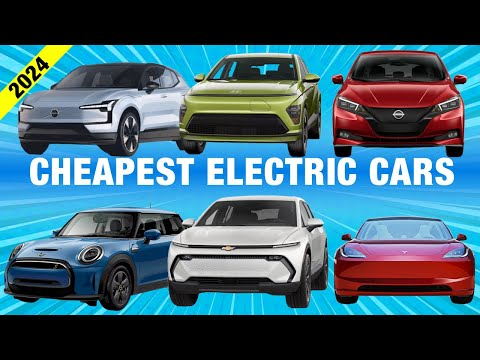

Views: 138687
Likes: 1270
Date Posted: 2024-02-08T17:00:01Z
Description:  Edmunds’ Nick Yekikian goes through the cheapest EVs currently available. Edmunds Cars: The Cheapest EVs You Can Buy Today. Most Affordable Electric Cars & SUVs for 2024, Edmunds.com


In [7]:
# Define the API request URL
url = f"https://www.googleapis.com/youtube/v3/videos?part=snippet,statistics&id={video_id}&key={userdata.get('YouTubeAPI_key')}"

# Send a GET request to the API
response = requests.get(url).json()

# Check if the response contains items
if "items" in response and response["items"]:
    # Extract required information
    video = response["items"][0]
    title = video["snippet"]["title"]
    thumbnail_url = video["snippet"]["thumbnails"]["high"]["url"]
    view_count = video["statistics"]["viewCount"]
    like_count = video["statistics"].get("likeCount", "Not available")  # Handle cases with no likeCount
    date_posted = video["snippet"]["publishedAt"]


    # Print the extracted information
    print("Channel Name:", processed_data['channel_name'])
    print("Title:", title)
    display(Image(thumbnail_url))
    print("Views:", view_count)
    print("Likes:", like_count)
    print("Date Posted:", date_posted)
    print("Description:", processed_data['video_description'])
else:
    print("No video found or invalid video ID.")


In [8]:
# Create the prompt text
prompt = f"""
You are given information about a YouTube channel's video, along with viewer sentiment and explanations from various comments. Summarize the overall interpretation of the sentiment and explanations provided.

Input:
{processed_data}

Instructions:
1. Review the input data, focusing on the sentiment and explanations.
2. Identify the general mood or attitude expressed by the viewers.
3. Provide an overall interpretation of the viewers' reactions and any specific themes or concerns they raise.

Output: A concise summary of the overall interpretation, highlighting the sentiment, key points, and any underlying motivations or concerns expressed by viewers in their comments.
"""


In [9]:
def recreate_dataset_without_comments(dataset):
    """
    Recreates a dataset by removing specific fields (`comment_text`, `like_count`, and `reply_count`)
    and aggregating `sentiment_&_explanations` based on `channel_name`, `video_title`, and `video_description`.

    Parameters:
    dataset (list of dict): The original dataset, where each dictionary contains fields such as
                            'channel_name', 'video_title', 'video_description', 'comment_text',
                            'like_count', 'reply_count', and 'sentiment_&_explanations'.

    Returns:
    list of dict: A list of dictionaries with each dictionary representing unique video details.
                  Each dictionary contains:
                  - 'channel_name': Name of the channel.
                  - 'video_title': Title of the video.
                  - 'video_description': Description of the video.
                  - 'sentiment_&_explanations_list': List of aggregated sentiment explanations for the video.
    """
    result = []
    video_dict = {}

    # Grouping sentiment explanations by unique video details
    for item in dataset:
        key = (item['channel_name'], item['video_title'], item['video_description'])
        if key not in video_dict:
            video_dict[key] = []
        video_dict[key].append(item['sentiment_&_explanations'])

    # Creating the result list with the desired format
    for key, sentiments in video_dict.items():
        result.append({
            'channel_name': key[0],
            'video_title': key[1],
            'video_description': key[2],
            'sentiment_&_explanations_list': sentiments
        })

    return result




In [10]:
new_video_dataset_dict = {}
# Recreate the dataset without 'comment_text', 'like_count', and 'reply_count'
for video_id, dataset in data.items():
  new_video_dataset_dict[video_id] = recreate_dataset_without_comments(dataset)

In [11]:
new_video_dataset_dict.keys()

dict_keys(['R_J_T7TWbXY', '1_qAM1e0E9k', 'zoRbWn5KckM', 'ocNfkVA28mg', 'UG1kaHSj-Qc', 'G67i_Z8ukD4', 'qxmhFRx2fOw', 'EtepwEMnFGA', 'vz4qnwNKxt4', '9DLwtGw5yZY', 'yGIDpXH1zZk', '77Yo4LpksWM', 'GHGXy_sjbgQ', 'HFmezRNd7Ds', 'Pt3hkv0ELvw', 'VGIORVjqWto', 'eBW1twZqLVo', 'Iyp_X3mwE1w', 'npg0AP4r5_E', 'M-EkMK4awX4', 'xNZR4wB-T80', 'mcMNXNhhBuE', 'ybl8IvhGAJ4', 'wkiZ7xV7zaM', 'bQSNMHOXO8U', '4gOFin8pGg4', 'eGS34ENu4S4', 'T7fGDw7U2Wg', 'psRsXp-Gekg', 'KmT31DaCGI0', 'xAZWgid2AMY', 'JXD9c3DZw8o', 'FIxT6rK02lk', 't0So_FxILM4', 'N1dveN6OeFA', 'tJfERzrG-D8', 'iJ5Fzx8_QBo', 'QVYsy7UZwrE', 'uGfiNP9Teio', 'qMzYHpi1GPM', 'uUv0QsDJr3o', 'O9SGkC5UDE4', 'VhUpWqmYxi4', 'fLflYkgnNBY', '9xIE9seg6Os', '3m_z27LJa6o', '06Q-BbvA48Q', 'KFGES0sESy0', '11nIlhjL0Cw', 'MOreJAyfUUU', '8X2x1LM43IE', 'Gc1kU5dizF8', 'qqUuHQsfg7I', '_FFdNselkRs', 'ODG59UjBiGg', 'Aa647ghOjGw'])

In [12]:
# prompt: create a list of all the values in the in new_video_dataset_dict

training_data = []
for key in new_video_dataset_dict:
  training_data.append(new_video_dataset_dict[key][0])


In [13]:
# data
training_data


# Verify the data structure and prepare input and target data based on prompt
input_texts = [
    f"""
    You are given information about a YouTube channel's video (Channel Name, Video Title, and Video Description are provided for context), along with viewer sentiment and explanations from various comments.
    Summarize and provide an overall interpretation of the sentiment and explanations provided.

    Channel Name: {video_data.get('channel_name', 'N/A')}
    Video Title: {video_data.get('video_title', 'N/A')}
    Video Description: {video_data.get('video_description', 'N/A')}

    Viewer Sentiments and Explanations:
    {video_data.get('sentiment_&_explanations_list', [])}

    Instructions:
    1. Review the input data, focusing on the sentiment and explanations.
    2. Identify the general mood or attitude expressed by the viewers.
    3. Provide an overall interpretation of the viewers' reactions and any specific themes or concerns they raise.
    """
    for video_data in training_data if isinstance(video_data, dict)
]

target_texts = [
    "A concise summary of the overall interpretation, highlighting the sentiment, key points, and any underlying motivations or concerns expressed by viewers in their comments."
    for _ in training_data
]



# Define a custom Dataset class
class EVSummaryDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_length=16384):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Tokenize the input text
        inputs = self.tokenizer(
            self.inputs[idx],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        targets = self.tokenizer(
            self.targets[idx],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        target_ids = targets.input_ids.squeeze()
        target_attention_mask = targets.attention_mask.squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": target_ids,
            "decoder_attention_mask": target_attention_mask
        }

# Collate function to properly stack and batch items
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    decoder_attention_mask = torch.stack([item['decoder_attention_mask'] for item in batch])

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "decoder_attention_mask": decoder_attention_mask
    }

# Specify the model name
model_name = 'allenai/led-base-16384'

# Load tokenizer and model
tokenizer = LEDTokenizer.from_pretrained(model_name)
model = LEDForConditionalGeneration.from_pretrained(model_name)

# Create Dataset and DataLoader
dataset = EVSummaryDataset(input_texts, target_texts, tokenizer)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Training loop
epochs = 12
for epoch in range(epochs):
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        # Move all batch data to the same device as the model
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

# Define paths to save the model and tokenizer
model_save_path = "./summaryInterp_trained_led-base-16384"
tokenizer_save_path = "./summaryInterp_trained_led-base-16384"

# After training, save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Epoch 1/12, Loss: 7.213507171188082
Epoch 2/12, Loss: 3.2017867054258073
Epoch 3/12, Loss: 1.968331332717623
Epoch 4/12, Loss: 1.0423110180667468
Epoch 5/12, Loss: 0.5185820987182004
Epoch 6/12, Loss: 0.28433938031750067
Epoch 7/12, Loss: 0.1784417706408671
Epoch 8/12, Loss: 0.12366807207997356
Epoch 9/12, Loss: 0.0916444237477013
Epoch 10/12, Loss: 0.07116299362054893
Epoch 11/12, Loss: 0.05717568252501743
Epoch 12/12, Loss: 0.047134386974253824


('./summaryInterp_trained_led-base-16384/tokenizer_config.json',
 './summaryInterp_trained_led-base-16384/special_tokens_map.json',
 './summaryInterp_trained_led-base-16384/vocab.json',
 './summaryInterp_trained_led-base-16384/merges.txt',
 './summaryInterp_trained_led-base-16384/added_tokens.json')

In [14]:
# Pushing to HuggingFace

model.push_to_hub("kkrusere/summaryInterp_trained_led-base-16384")
tokenizer.push_to_hub("kkrusere/summaryInterp_trained_led-base-16384")


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/648M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/kkrusere/summaryInterp_trained_led-base-16384/commit/d77797ca1d9921c79fffb1e413a43f79d94785b4', commit_message='Upload tokenizer', commit_description='', oid='d77797ca1d9921c79fffb1e413a43f79d94785b4', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
# # Function for generating a summary for a single input
# def generate_summary(text):
#     inputs = tokenizer(text, max_length=16384, truncation=True, return_tensors="pt").to("cuda")
#     summary_ids = model.generate(inputs.input_ids, max_length=150, num_beams=2, length_penalty=2.0, early_stopping=True)
#     return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# # Example generation
# for text in input_texts:
#     summary = generate_summary(text)
#     print("Generated Summary:", summary)

In [16]:
processed_data = retrieve_or_extract_video_data('https://www.youtube.com/watch?v=JXHaPjFbN_U')

S3 reference for video_id 'JXHaPjFbN_U' retrieved from DynamoDB.
Data for video_id 'JXHaPjFbN_U' retrieved from S3.
Data retrieved from AWS.


In [17]:
processed_data = recreate_dataset_without_comments(processed_data)

In [18]:
# Define paths where the model and tokenizer are saved
model_save_path = "./summaryInterp_trained_led-base-16384"
tokenizer_save_path = "./summaryInterp_trained_led-base-16384"

# Load the model and tokenizer
model = LEDForConditionalGeneration.from_pretrained(model_save_path)
tokenizer = LEDTokenizer.from_pretrained(tokenizer_save_path)

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [19]:
processed_data[0].keys()

dict_keys(['channel_name', 'video_title', 'video_description', 'sentiment_&_explanations_list'])

In [20]:
input_text = [
    f"""
    You are given information about a YouTube channel's video (Channel Name, Video Title, and Video Description are provided for context), along with viewer sentiment and explanations from various comments.
    Summarize and provide an overall interpretation of the sentiment and explanations provided.

    Channel Name: {video_data.get('channel_name', 'N/A')}
    Video Title: {video_data.get('video_title', 'N/A')}
    Video Description: {video_data.get('video_description', 'N/A')}

    Viewer Sentiments and Explanations:
    {video_data.get('sentiment_&_explanations_list', [])}

    Instructions:
    1. Review the input data, focusing on the sentiment and explanations.
    2. Identify the general mood or attitude expressed by the viewers.
    3. Provide an overall interpretation of the viewers' reactions and any specific themes or concerns they raise.
    """
    for video_data in processed_data if isinstance(video_data, dict)
]

In [23]:
def generate_summary(text, max_input_length=16384, max_output_length=16384):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        max_length=max_input_length,
        truncation=True,
        return_tensors="pt"
    ).to(device)  # Move inputs to the same device as the model

    # Generate the summary
    summary_ids = model.generate(
        inputs.input_ids,
        max_length=max_output_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    # Decode and return the summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
# Generate and print the summary
summary = generate_summary(input_text)
print("Generated Summary:", summary)